# 02 - Обзор основных алгоритмов Boosting 

In [2]:
if 0:
    !pip install -U xgboost
    !pip install -U lightgbm
    !pip install -U catboost

In [3]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('display.max_columns', None)
%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#### Загрузка данных

In [5]:
DATA_TRAIN = "../data/02/assignment_2_train.csv"
DATA_TEST = "../data/02/assignment_2_test.csv"

In [6]:
data = pd.read_csv(DATA_TRAIN)
print("data.shape = {} rows, {} cols".format(*data.shape))
data.head(n=2)

data.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test_data = pd.read_csv(DATA_TEST)
print("data_test.shape = {} rows, {} cols".format(*test_data.shape))
test_data.head(n=2)

data_test.shape = 100001 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Быстрый просмотр данных

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 300.6+ MB


In [10]:
ID_F = 'TransactionID'
TARGET_F = 'isFraud'
DT_F = 'TransactionDT'
NUMERICAL_F = data.select_dtypes(include=[np.number]).columns.drop([TARGET_F, ID_F])
CAT_F = data.select_dtypes(include='object').columns

In [11]:
NUMERICAL_F

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=378)

In [12]:
CAT_F

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [13]:
# pd.to_timedelta(tr_data[DT_F], unit='s')

### Подготовка данных для моделей

In [15]:
target = data[TARGET_F]
train_df = data.drop([ID_F, TARGET_F], axis=1)
print("tr_df.shape = {} rows, {} cols".format(*train_df.shape))

tr_df.shape = 180000 rows, 392 cols


#### Числовые данные

In [16]:
def make_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    return df[NUMERICAL_F]

In [17]:
num_df = make_numeric_df(train_df)

### Категориальные данные

In [18]:
def make_small_cat(col: pd.Series, level: float = 0.05) -> pd.Series:
    """ Заменяет значения признака на other если в отсортированной 
        по возрастанию коммулятивной сумме значение в диапазоне [0, level]
    """
    try:
        vc_p =col.value_counts(normalize=True,ascending=True)
        p_other_cat = vc_p[vc_p.cumsum() <= 0.05].index.to_list()
        return col.apply(lambda x: 'other' if x in p_other_cat else x)
    except Exception as err:
        print(f'Ошибка при обработке {col.name}')
        raise err

In [19]:
def make_category_df(df: pd.DataFrame) -> pd.DataFrame:
    cat_data = df[CAT_F].copy()
    # сократим кол-во категорий в мейлах
    cat_data['P_emaildomain'] = make_small_cat(cat_data['P_emaildomain'])
    cat_data['R_emaildomain'] = make_small_cat(cat_data['R_emaildomain'])
    # encoding бинарных переменных
    m_dict = {'T': 0, 'F': 1}
    m_cols = {'M1','M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'}
    for col in cat_data:
        if col in m_cols:
            print(col, end='')
            cat_data[col] = cat_data[col].apply(m_dict.get)
    print()
    # дальше все в дамми
    return pd.get_dummies(cat_data)

In [20]:
# обработанные категориальные
cat_df = make_category_df(train_df)

M1M2M3M5M6M7M8M9


In [21]:
# num+cat данные
prep_df = num_df.join(cat_df)

In [22]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 431 entries, TransactionDT to M4_M2
dtypes: float64(384), int64(2), uint8(45)
memory usage: 537.8 MB


In [24]:
# разбиваем все на трайн и валид
x_train, x_valid, num_train, num_valid, prep_train, prep_valid, y_train, y_valid = train_test_split(
    train_df, num_df, prep_df, target, train_size=0.75, stratify=target, random_state=1
)

In [25]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 135000 rows, 392 cols
x_valid.shape = 45000 rows, 392 cols


In [26]:
print("num_train.shape = {} rows, {} cols".format(*num_train.shape))
print("num_valid.shape = {} rows, {} cols".format(*num_valid.shape))

num_train.shape = 135000 rows, 378 cols
num_valid.shape = 45000 rows, 378 cols


In [27]:
print("prep_train.shape = {} rows, {} cols".format(*prep_train.shape))
print("prep_valid.shape = {} rows, {} cols".format(*prep_valid.shape))

prep_train.shape = 135000 rows, 431 cols
prep_valid.shape = 45000 rows, 431 cols


## XGBoost API

In [28]:
import xgboost as xgb

In [29]:
def train_xgb(params, x_train, x_valid, y_train, y_valid):
    
    dtrain = xgb.DMatrix(data=x_train, label=y_train)
    dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
    
    xg_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        verbose_eval=10,
        maximize=True,
    )
        
    return  xg_model


In [30]:
def cv_xgb(params, x_train, y_train, n_fold=5):
    dtrain = xgb.DMatrix(data=x_train, label=y_train)
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        verbose_eval=10,
        stratified=True,
        metrics="auc",
        maximize=True,
        shuffle=True,
        nfold=n_fold,
    )
    return cv_result

In [31]:
def plotXgbResult(cv_result):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(cv_result["train-auc-mean"], color="blue", linewidth=3, label="train")
    plt.plot(cv_result["test-auc-mean"], color="orange", linewidth=3, label="test")
    plt.fill_between(
        x=cv_result.index,
        y1=cv_result["train-auc-mean"] - cv_result["train-auc-std"],
        y2=cv_result["train-auc-mean"] + cv_result["train-auc-std"],
        alpha=0.25, color="blue"
    )
    plt.fill_between(
        x=cv_result.index,
        y1=cv_result["test-auc-mean"] - cv_result["test-auc-std"],
        y2=cv_result["test-auc-mean"] + cv_result["test-auc-std"],
        alpha=0.25, color="orange"
    )
    plt.title("XGBoost, CV-Results", size=14)
    plt.xlabel("n_iterations", size=14)
    plt.xlim(0, cv_result.index.max())
    plt.ylabel("ROC-AUC", size=14)
    plt.legend(loc="best")

In [56]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 1e-1,
    # "n_estimators": 250,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 42,
}
params['gpu_id'] = 1
params['tree_method'] = 'gpu_hist'


#### Тренируем и оцениваем модель - числовые данные

In [33]:
%%time
model = train_xgb(params, num_train, num_valid, y_train, y_valid)

[0]	train-auc:0.64819	valid-auc:0.65529
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.74610	valid-auc:0.74640
[20]	train-auc:0.82007	valid-auc:0.82447
[30]	train-auc:0.86097	valid-auc:0.86787
[40]	train-auc:0.86795	valid-auc:0.87335
[50]	train-auc:0.87952	valid-auc:0.88496
[60]	train-auc:0.88604	valid-auc:0.88955
[70]	train-auc:0.88928	valid-auc:0.89204
[80]	train-auc:0.89209	valid-auc:0.89382
[90]	train-auc:0.89510	valid-auc:0.89593
[100]	train-auc:0.89765	valid-auc:0.89777
[110]	train-auc:0.89932	valid-auc:0.89906
[120]	train-auc:0.89932	valid-auc:0.89906
[130]	train-auc:0.89932	valid-auc:0.89906
[140]	train-auc:0.89932	valid-auc:0.89906
[150]	train-auc:0.89932	valid-auc:0.89906
[160]	train-auc:0.89932	valid-auc:0.89906
[170]	train-auc:0.89932	valid-auc:0.89906
[180]	train-auc:0.89932	valid-auc:0.89906
[190]	train-auc:0.89932	valid-auc:0.89906
[200]	train-auc:0.89932	val

[0]	train-auc:0.62718+0.01094	test-auc:0.62467+0.01491
[10]	train-auc:0.77757+0.01413	test-auc:0.77465+0.02327
[20]	train-auc:0.82439+0.00455	test-auc:0.82047+0.00809
[30]	train-auc:0.85273+0.00603	test-auc:0.84898+0.00637
[40]	train-auc:0.86870+0.00143	test-auc:0.86369+0.00594
[50]	train-auc:0.87906+0.00104	test-auc:0.87292+0.00437
[60]	train-auc:0.88546+0.00107	test-auc:0.87838+0.00422
[70]	train-auc:0.88920+0.00097	test-auc:0.88141+0.00458
[80]	train-auc:0.89198+0.00103	test-auc:0.88377+0.00447
[90]	train-auc:0.89458+0.00094	test-auc:0.88583+0.00472
[100]	train-auc:0.89668+0.00073	test-auc:0.88742+0.00498
[110]	train-auc:0.89667+0.00072	test-auc:0.88743+0.00498
[120]	train-auc:0.89667+0.00072	test-auc:0.88743+0.00498
[130]	train-auc:0.89667+0.00072	test-auc:0.88743+0.00498
[140]	train-auc:0.89667+0.00072	test-auc:0.88743+0.00498
[150]	train-auc:0.89667+0.00072	test-auc:0.88743+0.00498
[160]	train-auc:0.89667+0.00072	test-auc:0.88743+0.00498
[170]	train-auc:0.89667+0.00072	test-auc:0

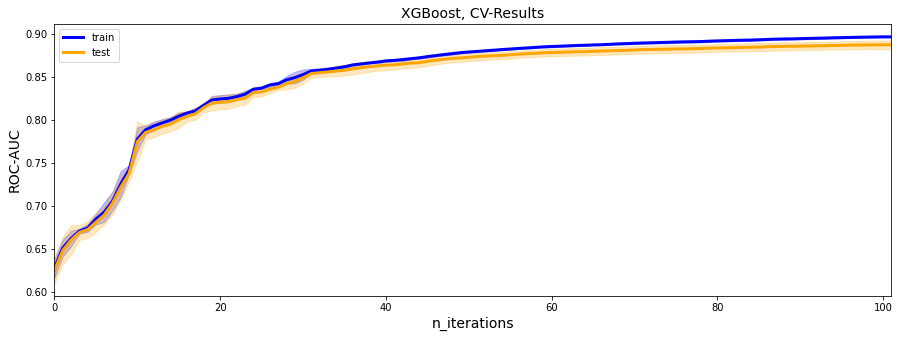

In [57]:
%%time
# кросвалидация
cv_xgb_num = cv_xgb(params, num_train, y_train)
plotXgbResult(cv_xgb_num)

#### Тренируем и оцениваем модель - числовые и обработанные категориальные

In [35]:
%%time
model = train_xgb(params, prep_train, prep_valid, y_train, y_valid)

[0]	train-auc:0.64819	valid-auc:0.65529
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.74610	valid-auc:0.74640
[20]	train-auc:0.81983	valid-auc:0.82434
[30]	train-auc:0.86089	valid-auc:0.86836
[40]	train-auc:0.87294	valid-auc:0.87844
[50]	train-auc:0.88426	valid-auc:0.88780
[60]	train-auc:0.89188	valid-auc:0.89390
[70]	train-auc:0.89637	valid-auc:0.89715
[80]	train-auc:0.90030	valid-auc:0.90037
[90]	train-auc:0.90348	valid-auc:0.90253
[100]	train-auc:0.90560	valid-auc:0.90403
[110]	train-auc:0.90783	valid-auc:0.90497
[120]	train-auc:0.90923	valid-auc:0.90609
[130]	train-auc:0.90923	valid-auc:0.90609
[140]	train-auc:0.90923	valid-auc:0.90609
[150]	train-auc:0.90923	valid-auc:0.90609
[160]	train-auc:0.90923	valid-auc:0.90609
[170]	train-auc:0.90923	valid-auc:0.90609
[180]	train-auc:0.90923	valid-auc:0.90609
[190]	train-auc:0.90923	valid-auc:0.90609
[200]	train-auc:0.90923	val

[0]	train-auc:0.62718+0.01094	test-auc:0.62467+0.01491
[10]	train-auc:0.77759+0.01414	test-auc:0.77467+0.02329
[20]	train-auc:0.82452+0.00473	test-auc:0.82056+0.00820
[30]	train-auc:0.85605+0.00445	test-auc:0.85167+0.00655
[40]	train-auc:0.87199+0.00122	test-auc:0.86674+0.00679
[50]	train-auc:0.88326+0.00106	test-auc:0.87713+0.00488
[60]	train-auc:0.89045+0.00071	test-auc:0.88319+0.00560
[70]	train-auc:0.89566+0.00078	test-auc:0.88793+0.00543
[80]	train-auc:0.89949+0.00093	test-auc:0.89136+0.00551
[90]	train-auc:0.90226+0.00118	test-auc:0.89387+0.00527
[100]	train-auc:0.90490+0.00118	test-auc:0.89598+0.00527
[110]	train-auc:0.90646+0.00145	test-auc:0.89738+0.00507
[120]	train-auc:0.90646+0.00145	test-auc:0.89738+0.00507
[130]	train-auc:0.90646+0.00145	test-auc:0.89738+0.00507
[140]	train-auc:0.90646+0.00145	test-auc:0.89738+0.00507
[150]	train-auc:0.90646+0.00145	test-auc:0.89738+0.00507
[160]	train-auc:0.90646+0.00145	test-auc:0.89738+0.00507
[170]	train-auc:0.90646+0.00145	test-auc:0

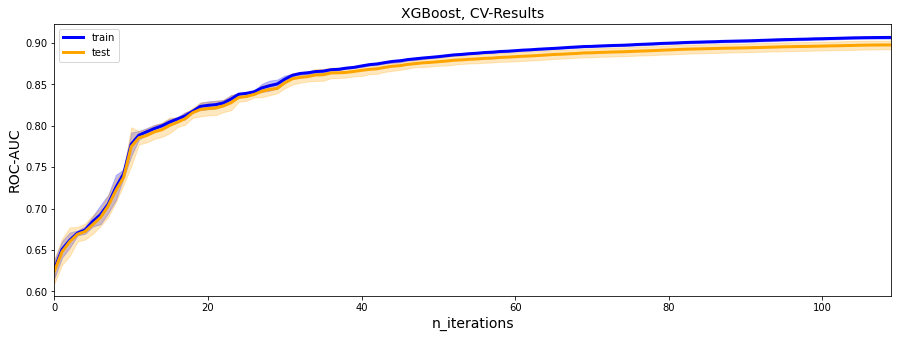

In [58]:
%%time
# кросвалидация
cv_xgb_prep = cv_xgb(params, prep_train, y_train)
plotXgbResult(cv_xgb_prep)

### Вывод по XGBoost

Добавление предобработанных данных повышает качество на 0,01 

## LightGBM


In [37]:
import lightgbm as lgb

In [89]:
def train_lgbm(params, x_train, x_valid, y_train, y_valid, cat_list='auto'):
    
    dtrain = lgb.Dataset(data=x_train, label=y_train)
    dvalid = lgb.Dataset(data=x_valid, label=y_valid)
    
    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=50,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        verbose_eval=50,
        categorical_feature="auto",
    )
        
    return  model

In [66]:
def cv_lgbm(params, x_train, y_train, n_fold=5):
    dtrain = lgb.Dataset(data=x_train, label=y_train)
    cv_result = lgb.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=50,
        categorical_feature="auto",
        verbose_eval=50,
        stratified=True,
        metrics="auc",
        shuffle=True,
        nfold=n_fold,
        eval_train_metric=True
    )
    return cv_result

In [ ]:
lgb.cv

In [67]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
#     "n_estimators": 250,
    'force_col_wise': True,
    "n_jobs": 6,
    "seed": 27
}
# params['device_type'] = 'gpu'
# params['gpu_platform_id'] = 0
# params['gpu_device_id'] = 1
# params['max_bin'] = 63
# params["boosting_type"] = "goss"

In [64]:
%%time
# числовые данные
model = train_lgbm(params, num_train, num_valid, y_train, y_valid)

[LightGBM] [Info] Number of positive: 3856, number of negative: 131144
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 135000, number of used features: 376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028563 -> initscore=-3.526666
[LightGBM] [Info] Start training from score -3.526666
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.87376	valid's auc: 0.876981
[100]	train's auc: 0.889835	valid's auc: 0.889648
[150]	train's auc: 0.901469	valid's auc: 0.898772
[200]	train's auc: 0.910303	valid's auc: 0.905218
[250]	train's auc: 0.919784	valid's auc: 0.90989
[300]	train's auc: 0.926771	valid's auc: 0.913232
[350]	train's auc: 0.932686	valid's auc: 0.91684
[400]	train's auc: 0.936827	valid's auc: 0.919423
[450]	train's auc: 0.940738	valid's auc: 0.922061
[500]	train's auc: 0.944073	valid's auc: 0.923892
[550]	train's auc: 0.948033	valid's auc: 0.926292
[600]	train's auc: 0.951111	valid's auc: 0.928175
[650]	tr

In [68]:
%%time
# кросвалидация
cv_lgbm_num = cv_lgbm(params, num_train, y_train)

[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Number of positive: 3084, number of negative: 104916
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features:

In [76]:
cv_lgbm_num.keys()
# plotXgbResult(cv_lgbm_num)

dict_keys(['auc-mean', 'auc-stdv'])

In [79]:
%%time
# num + cat подготовленнные
model = train_lgbm(params, prep_train, prep_valid, y_train, y_valid)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3856, number of negative: 131144
[LightGBM] [Info] Total Bins 31612
[LightGBM] [Info] Number of data points in the train set: 135000, number of used features: 427
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028563 -> initscore=-3.526666
[LightGBM] [Info] Start training from score -3.526666
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.878613	valid's auc: 0.881964
[100]	train's auc: 0.897259	valid's auc: 0.897807
[150]	train's auc: 0.907622	valid's auc: 0.904398
[200]	train's auc: 0.91616	valid's auc: 0.909759
[250]	train's auc: 0.926076	valid's auc: 0.915467
[300]	train's auc: 0.93396	valid's auc: 0.920033
[350]	train's auc: 0.940227	valid's auc: 0.923485
[400]	train's auc: 0.944911	valid's auc: 0.926196
[450]	train's auc: 0.949262	valid's auc: 0.9288

In [103]:
def make_categoty_type(df):
    data = df.copy()
    for feature in CAT_F:
        print(feature, end=' ')
        data[feature] = pd.Series(data[feature], dtype="category")
    print()
    return data

In [100]:
lgbm_train = make_categoty_type(x_train)
lgbm_valid = make_categoty_type(x_valid)

ProductCD card4 card6 P_emaildomain R_emaildomain M1 M2 M3 M4 M5 M6 M7 M8 M9 
ProductCD card4 card6 P_emaildomain R_emaildomain M1 M2 M3 M4 M5 M6 M7 M8 M9 


In [101]:
%%time
# сырые данные с автоматической обработкой
model = train_lgbm(params, lgbm_train, lgbm_valid, y_train, y_valid, list(CAT_F))

[LightGBM] [Info] Number of positive: 3856, number of negative: 131144
[LightGBM] [Info] Total Bins 31666
[LightGBM] [Info] Number of data points in the train set: 135000, number of used features: 390


d:\_dl_pytorch_\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\_dl_pytorch_\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028563 -> initscore=-3.526666
[LightGBM] [Info] Start training from score -3.526666
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.876066	valid's auc: 0.879463
[100]	train's auc: 0.899913	valid's auc: 0.89755
[150]	train's auc: 0.910151	valid's auc: 0.905915
[200]	train's auc: 0.91916	valid's auc: 0.912087
[250]	train's auc: 0.927106	valid's auc: 0.917703
[300]	train's auc: 0.934509	valid's auc: 0.921847
[350]	train's auc: 0.940721	valid's auc: 0.924578
[400]	train's auc: 0.945625	valid's auc: 0.926998
[450]	train's auc: 0.950085	valid's auc: 0.929761
[500]	train's auc: 0.954525	valid's auc: 0.932758
[550]	train's auc: 0.95791	valid's auc: 0.934601
[600]	train's auc: 0.960727	valid's auc: 0.936537
[650]	train's auc: 0.963295	valid's auc: 0.938227
[700]	train's auc: 0.965344	valid's auc: 0.939388
[750]	train's auc: 0.96729	valid's auc: 0.940176
[800]	train's auc: 0.968998	valid's auc: 0.940774
[850]	trai

## CatBoost

In [ ]:
import catboost as cb